In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from help_functions.evaluate_energymodels import evaluate_different_energymodels
from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers


from energy_consumption.models.lasso.lasso import get_Lasso_forecasts
from energy_consumption.models.baseline import get_baseline_forecasts
from energy_consumption.models.knn.knn import get_KNNRegression_forecasts
from energy_consumption.models.XGBoost.XGBoost import get_XGBoost_forecasts
from energy_consumption.models.quantreg.quantreg_ex import get_QuantRegExShort_forecasts
from energy_consumption.models.quantreg.quantreg_end import get_QuantRegEndShort_forecasts
from energy_consumption.models.quantreg.quantreglags import get_QuantRegExLags_forecasts

In [2]:
energydata = pd.read_csv(
        'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")
energydata = impute_outliers(energydata)

In [2]:
from energy_consumption.feature_selection.extract.extract_energy_data import get_data
energydata = get_data()

100%|██████████| 364/364 [03:51<00:00,  1.57it/s]


In [5]:
import numpy as np
import pandas as pd

from energy_consumption.feature_selection.extract import extract_energy_data

# import required models
from energy_consumption.models.lasso.lasso import get_Lasso_forecasts
from energy_consumption.models.knn.knn import get_KNNRegression_forecasts
from energy_consumption.models.XGBoost.XGBoost import get_XGBoost_forecasts
from energy_consumption.models.quantreg.quantreg_end import get_QuantRegEndShort_forecasts
from energy_consumption.models.quantreg.quantreglags import get_QuantRegExLags_forecasts


def combine_selected_models(energydata=np.nan):

    if type(energydata) == float:
        # use derived optimum for number of years
        energydata = extract_energy_data.get_data()

    QuantRegEndShort_forecasts = get_QuantRegEndShort_forecasts(energydata)
    Lasso_forecasts = get_Lasso_forecasts(energydata)  # corrected
    XGBoost_forecasts = get_XGBoost_forecasts(energydata)
    KNN_forecasts = get_KNNRegression_forecasts(energydata)
    QuantRegExLags = get_QuantRegExLags_forecasts(energydata)

    combined_model = pd.DataFrame(  # corrected
        index=Lasso_forecasts.index, columns=Lasso_forecasts.columns)
    combined_model.loc[:, 'q0.025':'q0.975'] = np.nan

    combined_model.loc[:, 'q0.025':'q0.975'].iloc[0] = np.array(
        XGBoost_forecasts.loc[:, 'q0.025':'q0.975'].iloc[0])*0.4 + np.array(QuantRegExLags.loc[:, 'q0.025':'q0.975'].iloc[0])*0.5 + np.array(QuantRegEndShort_forecasts.loc[:, 'q0.025':'q0.975'].iloc[0])*0.1
    combined_model.loc[:, 'q0.025':'q0.975'].iloc[1] = np.array(
        XGBoost_forecasts.loc[:, 'q0.025':'q0.975'].iloc[1])*0.7 + np.array(QuantRegExLags.loc[:, 'q0.025':'q0.975'].iloc[1])*0.2 + np.array(Lasso_forecasts.loc[:, 'q0.025':'q0.975'].iloc[1])*0.1
    combined_model.loc[:, 'q0.025':'q0.975'].iloc[2] = np.array(
        XGBoost_forecasts.loc[:, 'q0.025':'q0.975'].iloc[2])*0.6 + np.array(QuantRegEndShort_forecasts.loc[:, 'q0.025':'q0.975'].iloc[2])*0.1 + np.array(KNN_forecasts.loc[:, 'q0.025':'q0.975'].iloc[2])*0.2 + np.array(Lasso_forecasts.loc[:, 'q0.025':'q0.975'].iloc[2])*0.05 + np.array(QuantRegExLags.loc[:, 'q0.025':'q0.975'].iloc[2])*0.05
    combined_model.loc[:, 'q0.025':'q0.975'].iloc[3] = np.array(
        XGBoost_forecasts.loc[:, 'q0.025':'q0.975'].iloc[3])*(1/4) + np.array(Lasso_forecasts.loc[:, 'q0.025':'q0.975'].iloc[3])*(3/8) + np.array(QuantRegExLags.loc[:, 'q0.025':'q0.975'].iloc[3])*(1/8) + np.array(KNN_forecasts.loc[:, 'q0.025':'q0.975'].iloc[3])*0.25
    combined_model.loc[:, 'q0.025':'q0.975'].iloc[4] = np.array(
        XGBoost_forecasts.loc[:, 'q0.025':'q0.975'].iloc[4])*(1/4) + np.array(Lasso_forecasts.loc[:, 'q0.025':'q0.975'].iloc[4])*(3/8) + np.array(QuantRegExLags.loc[:, 'q0.025':'q0.975'].iloc[4])*(2/8) + + np.array(KNN_forecasts.loc[:, 'q0.025':'q0.975'].iloc[4])*(1/8)
    combined_model.loc[:, 'q0.025':'q0.975'].iloc[5] = np.array(
        XGBoost_forecasts.loc[:, 'q0.025':'q0.975'].iloc[5])*(1/3) + np.array(Lasso_forecasts.loc[:, 'q0.025':'q0.975'].iloc[5])*(1/3) + np.array(QuantRegExLags.loc[:, 'q0.025':'q0.975'].iloc[5])*(1/3)

    combined_model['date_time'] = QuantRegEndShort_forecasts['date_time']
    combined_model['forecast_date'] = QuantRegEndShort_forecasts['forecast_date']
    combined_model['target'] = QuantRegEndShort_forecasts['target']
    combined_model['horizon'] = QuantRegEndShort_forecasts['horizon']

    return combined_model

In [21]:
energydata = get_data()

100%|██████████| 364/364 [03:47<00:00,  1.60it/s]


In [4]:
energydata

,energy_consumption
date_time,
2017-02-20 00:00:00,48.70375
2017-02-20 01:00:00,47.03750
2017-02-20 02:00:00,46.68325
2017-02-20 03:00:00,47.35025
2017-02-20 04:00:00,49.38725
...,...
2024-02-07 08:00:00,69.01400
2024-02-07 09:00:00,69.30350
2024-02-07 10:00:00,70.51450


In [ ]:
# Functions work

baseline = {
    'name': 'Baseline Model',
    'function': get_baseline_forecasts
}

lasso = {
    'name': 'Lasso Regression',
    'function': get_Lasso_forecasts
}

quantregshortex = {
    'name': "Quantile Regression Ex",
    'function': get_QuantRegExShort_forecasts
}

quantregshortend = {
    'name': "Quantile Regression End",
    'function': get_QuantRegEndShort_forecasts
}

quantregexlags= {
    'name': "Quantile Regression Ex Lags",
    'function': get_QuantRegExLags_forecasts
}

knn = {
    'name': 'KNN Regression',
    'function': get_KNNRegression_forecasts
}

xgboost = {
    'name': 'XGBoost Regression', 
    'function': get_XGBoost_forecasts
}

combi = {
    'name': 'combination', 
    'function': combine_selected_models
}

models = [baseline, lasso, quantregexlags, quantregshortend, knn, xgboost, combi]
evaluation = evaluate_different_energymodels(
    models, energydata, last_x=20, years=False, months=False, weeks=True)

### Visualize Comparison 

1. Create a table that only contains the different scores of the different models

In [ ]:
models[0]['evaluation']

In [7]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1, keys=names)

In [8]:
quantile_scores_per_model = {}

for m in range(0,len(models)):
    quantile_scores = {}
    evaluation_frame = models[m]['evaluation']
    for h in horizons: 
        day_frame = evaluation_frame.loc[evaluation_frame['horizon'] == h]
        quantile_scores.update({h: np.mean(day_frame['score'])})
    
    quantile_scores_per_model.update({models[m]['name']: quantile_scores})

quantile_scores_per_model
    

{'Baseline Model': {'36 hour': 12.098238611111103,
  '40 hour': 13.76616375,
  '44 hour': 11.231437881944448,
  '60 hour': 9.99558822916667,
  '64 hour': 13.769447187499999,
  '68 hour': 9.962742812500004},
 'Lasso Regression': {'36 hour': 10.495316448447474,
  '40 hour': 10.500739297878363,
  '44 hour': 8.719412673401237,
  '60 hour': 9.053109032614538,
  '64 hour': 9.843325067956506,
  '68 hour': 7.723429842130764},
 'Quantile Regression Ex Lags': {'36 hour': 7.469896696205282,
  '40 hour': 7.052085080786793,
  '44 hour': 8.622698953474224,
  '60 hour': 8.658428027929087,
  '64 hour': 8.331605262530996,
  '68 hour': 6.199677939926918},
 'Quantile Regression End': {'36 hour': 9.840882411821198,
  '40 hour': 9.920457182555502,
  '44 hour': 9.214337266628323,
  '60 hour': 11.206149046643986,
  '64 hour': 12.760142208112306,
  '68 hour': 10.727951975920709},
 'KNN Regression': {'36 hour': 15.88053299025678,
  '40 hour': 15.14193083078611,
  '44 hour': 9.292223347000638,
  '60 hour': 9.66

In [25]:
for m in range(0, len(models)):
    quantile_scores = {}
    evaluation_frame = models[m]['evaluation']
    for h in horizons:
        day_frame = evaluation_frame.loc[evaluation_frame['horizon'] == h]
        quantile_scores.update({h: np.var(day_frame['score'])})

    quantile_scores_per_model.update({models[m]['name']: quantile_scores})

quantile_scores_per_model

{'Baseline Model': {'36 hour': 53.17492618104324,
  '40 hour': 61.535582415894595,
  '44 hour': 48.36617624128727,
  '60 hour': 56.38309310059172,
  '64 hour': 76.09553964699279,
  '68 hour': 32.04738091650774},
 'Lasso Regression': {'36 hour': 44.978429281156444,
  '40 hour': 38.73456811434518,
  '44 hour': 45.37382505375292,
  '60 hour': 27.703815421998016,
  '64 hour': 46.992308414636824,
  '68 hour': 22.94144997098706},
 'Quantile Regression Ex Lags': {'36 hour': 25.915171871592644,
  '40 hour': 44.16112853351771,
  '44 hour': 60.200964728194776,
  '60 hour': 198.6331417752155,
  '64 hour': 193.87377548975064,
  '68 hour': 83.83807397160382},
 'Quantile Regression End': {'36 hour': 25.219612794691574,
  '40 hour': 38.609037102460086,
  '44 hour': 15.149718783004282,
  '60 hour': 47.355004928015234,
  '64 hour': 75.1534040412161,
  '68 hour': 35.77073891085972},
 'KNN Regression': {'36 hour': 45.96237500336046,
  '40 hour': 59.67153662589775,
  '44 hour': 10.450316051830352,
  '60 h

In [26]:
# Assume scores is a dictionary where keys are model names and values are lists of scores for each horizon
scores = {
    'Baseline Model': [12.030, 13.413, 11.026, 9.909, 13.490, 9.706],
    'Lasso Regression': [10.299, 10.200, 8.555, 8.984, 9.749, 7.730],
    'Quantile Regression Ex Lags': [6.833, 7.432, 8.228, 10.501, 10.142, 7.144],
    'Quantile Regression End': [9.939, 10.034, 9.403, 11.396, 12.921, 10.678],
    'KNN Regression': [15.696, 14.783, 9.020, 9.627, 10.419, 11.018],
    'XGBoost Regression': [7.500, 6.773, 6.279, 9.686, 10.483, 8.662],
    'Combined Model': [5.741, 5.677, 2.716, 6.611, 6.083, 3.231]
}

# Step 1: Normalize scores
normalized_scores = {model: [
    score / max(scores[model]) for score in scores[model]] for model in scores}

# Step 2: Weight Calculation
weights = {model: [1 / score for score in normalized_scores[model]]
           for model in normalized_scores}

# Step 3: Normalize weights
normalized_weights = {model: [
    weight / sum(weights[model]) for weight in weights[model]] for model in weights}

# Step 4: Combine Forecasts
combined_forecasts = []
for horizon in range(len(scores['Baseline Model'])):
    combined_forecast = sum([normalized_weights[model][horizon]
                            * scores[model][horizon] for model in normalized_weights])
    combined_forecasts.append(combined_forecast)

print("Combined Forecasts:", combined_forecasts)

Combined Forecasts: [10.499109855559501, 10.499109855559503, 10.499109855559503, 10.499109855559501, 10.499109855559501, 10.499109855559501]


In [ ]:
models[3]['evaluation'][models[3]['evaluation']['horizon'] == '40 hour']

In [27]:
score_summary = pd.DataFrame()
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']


mean_score ={} # model, horizon, mean_score
for h in horizons: 
    mean_scores = []
    for m in models: 
        m_score = np.mean(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        mean_scores.append(m_score)
    score_summary[h] = mean_scores

score_summary

,36 hour,40 hour,44 hour,60 hour,64 hour,68 hour
0,12.029923,13.412718,11.025705,9.909314,13.490310,9.705684
1,10.299162,10.200517,8.554674,8.984036,9.748597,7.729991
2,6.833216,7.431636,8.227509,10.501259,10.142157,7.144350
3,9.939310,10.033853,9.402755,11.395860,12.920981,10.677648
4,15.695910,14.783213,9.020343,9.626554,10.418800,11.017791
5,6.838611,6.323160,5.571960,9.077679,10.438870,8.670028
6,5.354336,4.909389,3.852556,6.735332,6.476404,4.655518


In [17]:
250*7/365

4.794520547945205

In [28]:
score_summary = pd.DataFrame()
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

var_score = {}  # model, horizon, mean_score
for h in horizons:
    var_scores = []
    for m in models:
        m_score = np.var(m['evaluation']['score']
                          [m['evaluation']['horizon'] == h])
        var_scores.append(m_score)
    score_summary[h] = var_scores

score_summary

,36 hour,40 hour,44 hour,60 hour,64 hour,68 hour
0,53.174926,61.535582,48.366176,56.383093,76.095540,32.047381
1,44.978429,38.734568,45.373825,27.703815,46.992308,22.941450
2,25.915172,44.161129,60.200965,198.633142,193.873775,83.838074
3,25.219613,38.609037,15.149719,47.355005,75.153404,35.770739
4,45.962375,59.671537,10.450316,17.116985,32.141580,30.696645
5,20.743787,21.817176,32.983628,78.789745,61.993791,60.159711
6,13.666087,11.877002,4.334563,10.107668,13.808690,9.693316


In [8]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
mean_scores = []
var_scores = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

In [9]:
250*7/365

4.794520547945205

2.  Plot the densities of the obtained scores

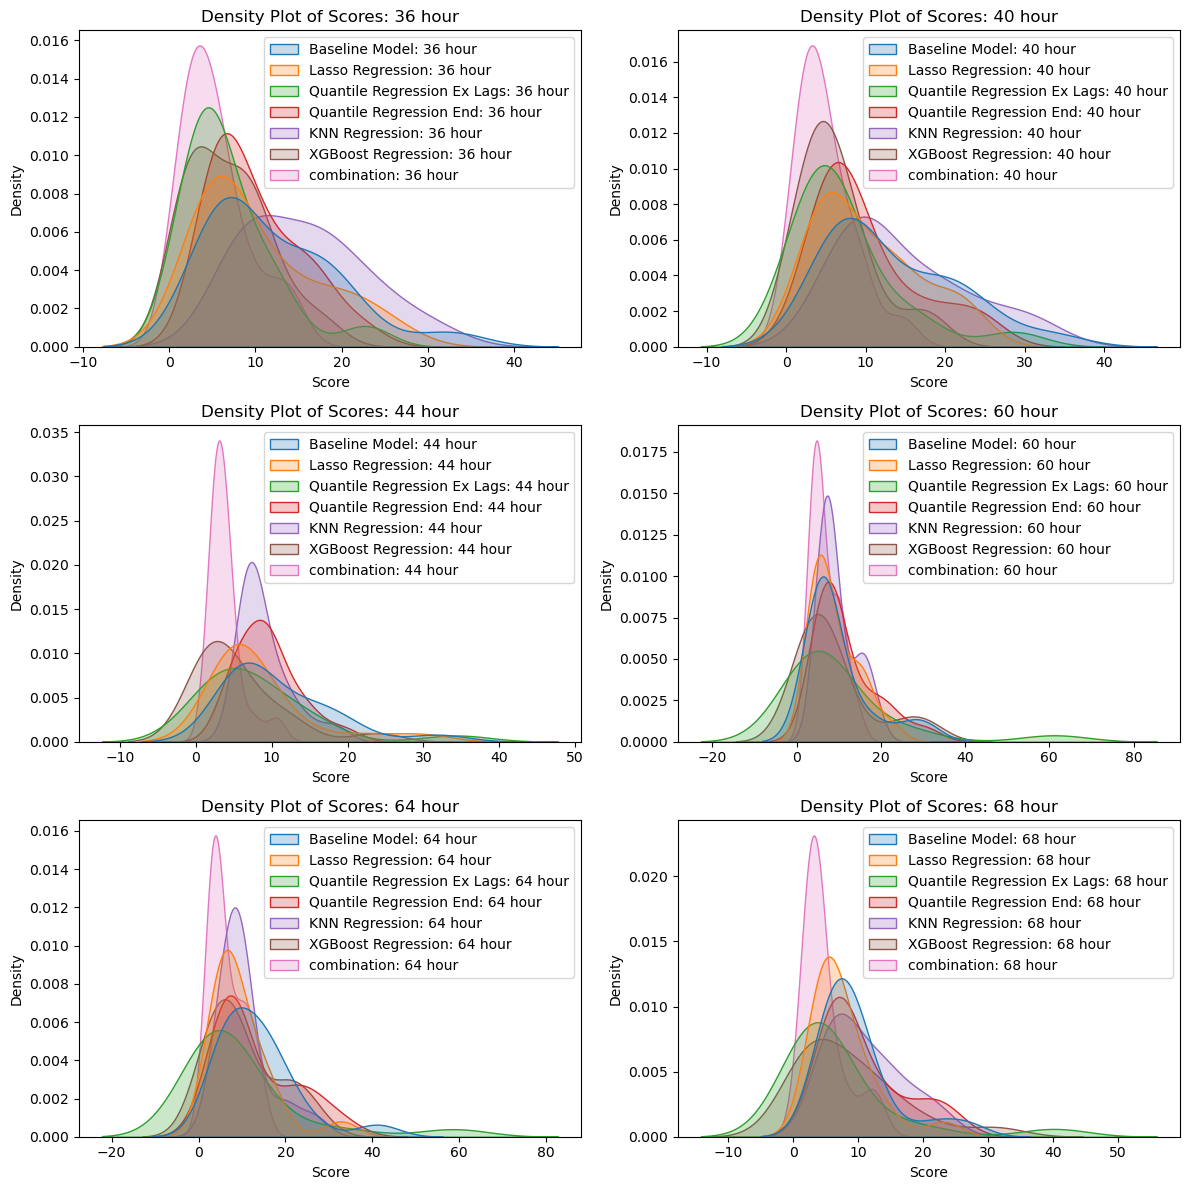

In [29]:
# Create subplots
fig, axes = plt.subplots(3,2, figsize=(12,12))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through each horizon
for i, h in enumerate(horizons):
    # Select columns related to the current horizon
    relevant_cols = [f'{m["name"]}: {h}' for m in models]

    # Filter the relevant data for the current horizon
    data_subset = score_df.loc[:, relevant_cols]

    # Create a KDE plot for the current horizon
    sns.kdeplot(data=data_subset, fill=True, ax=axes[i])

    # Set labels and title for each subplot
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Density Plot of Scores: {h}')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Display the plots
plt.show()

Best Models (for combination): 


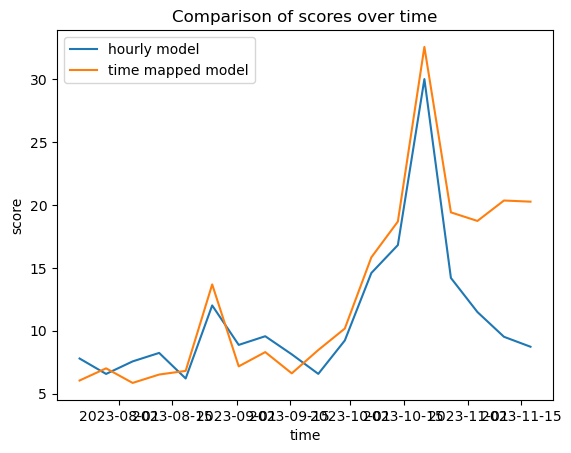

In [14]:
# Plot values from two columns over time
score_df_36_no_na = score_df[score_df['seasonal model hourly: 36 hour'].notna(
)]
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['seasonal model hourly: 36 hour'], label='hourly model')

plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['seasonal model with time mapping: 36 hour'], label='time mapped model')

# Adding labels and title
plt.xlabel('time')
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()